In [1]:
from packages import *
import numpy as np, matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.callbacks import TensorBoard
%load_ext autoreload
%autoreload 2

In [2]:
K.set_floatx('float32')
config = ConfigProto()
config.gpu_options.allow_growth = True
session = None
if session is not None:
    session.close()
session = InteractiveSession(config=config)

# Model

In [19]:
class BaselineModel(Model):
    def __init__(self, input_shape = INPUT_SHAPE,cat_type_units=3, cat_units=50, attr_units=1000):
        super(BaselineModel, self).__init__()
        self.inception_v4 = InceptionResNetV2(input_shape=INPUT_SHAPE,include_top=False, 
                                              weights='imagenet', pooling='avg')
        self.inception_v4.trainable = False
        self.dropout = Dropout(rate=.2)
        self.flatten = Flatten()
        self.cat_type = Dense(cat_type_units, activation='softmax', name='cat_type')
        self.cat = Dense(cat_units, activation='softmax', name='cat')
        self.attr = Dense(attr_units, activation='sigmoid', name='attr')
        
    def call(self, input_tensor, training=False):
        x = self.inception_v4(input_tensor)
        x = self.flatten(x)
        x = self.dropout(x)
        cat_type = self.cat_type(x)
        cat = self.cat(x)
        attr = self.attr(x)
        return (cat_type, cat, attr)

In [4]:
def generate_template(train=True, val=True, test=False):
    dataset = {}
    if train:
        dataset['train'] = {'x': [], 'cat_type': [], 'cat': [], 'attr': []}
    if val:
        dataset['val'] = {'x': [], 'cat_type': [], 'cat': [], 'attr': []}
    if test:
        dataset['test'] = {'x': [], 'cat_type': [], 'cat': [], 'attr': []}
    return dataset

In [5]:
def load_dataset(dataset_dir, splits, train=True, val=True, test=False):
    dataset=generate_template(train, val, test)
    assert len(splits) > 0, 'splits cannot be empty'
    i=0
    for s in dataset:
        s_dir = os.path.join(dataset_dir, s)
        for split in splits:
            dataset[s]['x'].append(np.load( os.path.join(s_dir, 'X', 'x_{}.npy'.format(split+1)),fix_imports=False, 
                                          allow_pickle=False))
            dataset[s]['cat_type'].append(np.load( os.path.join(s_dir, 'cat_type', 'cat_type_{}.npy'.format(split+1)),fix_imports=False, 
                                          allow_pickle=False))
            dataset[s]['cat'].append(np.load( os.path.join(s_dir, 'cat', 'cat_{}.npy'.format(split+1)),fix_imports=False, 
                                          allow_pickle=False))
            dataset[s]['attr'].append(np.load( os.path.join(s_dir, 'attr', 'attr_{}.npy'.format(split+1)),fix_imports=False, 
                                          allow_pickle=False))
            i+=1
            print('*Loaded {} out of {}*'.format(i, len(splits) * len(dataset)), end=' ')
        dataset[s]['x'] = np.concatenate(dataset[s]['x'])
        dataset[s]['cat_type'] = np.concatenate(dataset[s]['cat_type']) - 1
        dataset[s]['cat'] = np.concatenate(dataset[s]['cat']) -1
        dataset[s]['attr'] = np.concatenate(dataset[s]['attr']) 
    return dataset

In [6]:
model = Extractor()

In [7]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
loss = ['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'binary_crossentropy']
metrics = ['accuracy']
model.compile(optimizer=sgd, loss=loss, metrics=metrics)

In [8]:
splits = [1, 2, 3]
dataset = load_dataset(DATASET_DIR, splits)

*Loaded 1 out of 6* *Loaded 2 out of 6* *Loaded 3 out of 6* *Loaded 4 out of 6* *Loaded 5 out of 6* *Loaded 6 out of 6* 

In [10]:
x = dataset['train']['x']
y = [dataset['train']['cat_type'], dataset['train']['cat'], dataset['train']['attr']]
validation_data = (dataset['val']['x'], 
                   {'cat_type': dataset['val']['cat_type'], 
                    'cat': dataset['val']['cat'], 
                    'attr': dataset['val']['attr']}

In [11]:
batch_size=64

In [12]:
plot_model

Train on 62766 samples, validate on 12000 samples
   64/62766 [..............................] - ETA: 3:55:19 - loss: 5.8164 - output_1_loss: 1.0879 - output_2_loss: 4.0142 - output_3_loss: 0.7143 - output_1_accuracy: 0.4688 - output_2_accuracy: 0.0312 - output_3_accuracy: 0.4951

W0517 19:32:48.088760 139640623384384 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (1.107625). Check your callbacks.


62766/62766 [==============================] - 588s 9ms/sample - loss: 2.9065 - output_1_loss: 0.6228 - output_2_loss: 2.0086 - output_3_loss: 0.2751 - output_1_accuracy: 0.7410 - output_2_accuracy: 0.4367 - output_3_accuracy: 0.9619 - val_loss: 2.4682 - val_output_1_loss: 0.5467 - val_output_2_loss: 1.7988 - val_output_3_loss: 0.1228 - val_output_1_accuracy: 0.7788 - val_output_2_accuracy: 0.4833 - val_output_3_accuracy: 0.9967


## How did we do?
Now that we have trained our model for 1 epoch, let's see how well we did by plotting some examples to unseen validation data.

In [19]:
cat_type_preds = np.argmax(preds[0], axis=1)

In [60]:
cat_preds = np.argmax(preds[1], axis=1)

In [73]:
attr = load_pickle(os.path.join(LINK_DIR, 'attr.pkl'))
cat = load_pickle(os.path.join(LINK_DIR, 'cat.pkl'))
cat_types = load_pickle(os.path.join(LINK_DIR, 'cat_types_str.pkl'))

W0517 18:37:56.858155 139854661814080 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


upper
upper


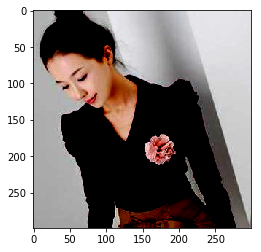

In [98]:
i = np.random.randint(0, len(dataset['val']['cat']))
plt.imshow(dataset['val']['x'][i].astype(np.float32))
print(cat_types[cat_type_preds[i]+1])
print(cat_types[dataset['val']['cat_type'][i] + 1])